In [139]:
import numpy as np
import inspect
import os
import sklearn
import math
from sklearn.manifold import TSNE
from sklearn import manifold, mixture, cluster
from sqlalchemy import func, select as sqlselect, distinct, text as sqltext
from matplotlib import pylab
import matplotlib.colors as colors
import matplotlib.cm as cmx
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
import functools
import random
from operator import itemgetter
from itertools import islice
import importlib
from datetime import datetime, timedelta

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir)

from server import db, user_library as ul, server
from server.models import *
from server import song_helper, music_graph_helper as mgh
from common.user_base import UserBase
importlib.reload(song_helper)
importlib.reload(mgh)
importlib.reload(ul)
importlib.reload(song_helper)
from common import spotify_helper
from common.common import *

spotify_helper.refresh_token_on_expired = True
%matplotlib inline

db.session.rollback()
server.start(start_mq=False)

--------------------------------------------------------------------------------
INFO in server [/vagrant/sleep_server/server/server.py:151]:
Server runtime starting
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DEBUG in music_graph_helper [/vagrant/sleep_server/server/music_graph_helper.py:432]:
1380 nodes, 951510 possible edges, 530918 real edges, 0.557974 prob of an edge
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DEBUG in music_graph_helper [/vagrant/sleep_server/server/music_graph_helper.py:441]:
----prob of 0 edges = 0.572367, 406897 noise edges may be stil created
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DEBUG in music_graph_helpe

In [99]:
library = ul.load_library('rudolfix-us')
lib_song_features, _ = mgh.load_user_library_song_features(library)
lib_song_features, _, _ = mgh.prepare_songs(lib_song_features, mgh.G.features_scaler)

In [133]:
def best_song_idx_with_genre(song_features, gid, min_duration_ms, max_duration_ms, f_affinity_threshold, randlimit):
    def best_dist(song):
        artist_id = int(song[mgh._f_artist_id_i])
        duration_ms = int(song[mgh._f_duration_id_i])
        if artist_id in mgh.G.artists_genres and gid in mgh.G.artists_genres[artist_id] and f_affinity_threshold(song) and \
            duration_ms < max_duration_ms and duration_ms > min_duration_ms:
            return mgh.lib_song_wake_preference(song)
        else:
            return -1
    # for x in np.nditer(a, flags=['external_loop'], order='F'): but you need to transpose a
    distances = np.apply_along_axis(best_dist, 1, song_features)
    print('best_idx choose among %i' % len(distances[distances>-1]))
    if np.all(distances == -1):
        return mgh.first_song_idx_with_genre(song_features, gid)
    else:
        # get only != -1
        sorted_idxs = np.argsort(distances)
        sorted_idxs = sorted_idxs[distances[sorted_idxs] > -1][::-1][:randlimit]
        r_idx = random.randint(0, min(randlimit - 1, len(distances) - 1))
        print('choose from %s idx %i' % (sorted_idxs, r_idx))
        return sorted_idxs[r_idx]
    
    
def find_closest_nodes_subgraph(G, source, targets):
    distances = []
    min_len = nx.number_of_nodes(G) + 1
    for t in targets:
        try:
            l = len(nx.dijkstra_path(G, source, t, weight='weight'))
        except nx.NetworkXNoPath:
            l = nx.number_of_nodes(G) + 1
        if l < min_len:
            min_len = l
        distances.append((t, l))
        
    return [l for l in distances if l[1] == min_len]


def find_by_acoustics(source, targets):
    sound_similarity = [3,4,5]
    end_idx = mgh.find_closest_genre_by_acoustics(mgh.G.genre_features[source],
                                                 mgh.G.genre_features[np.asarray(targets, dtype=np.int32)],
                                                 sound_similarity)
    
    return [(targets[end_idx], -1)]


def generate_wakeup_playlist(wake_gid, lib_wake_song_features, gr_song_features, top_sleep_genres,
                            top_genres, desired_length):
    wake_song_features = lib_wake_song_features[:, :mgh._f_lib_feats_i]
    # find #start genre song and then #end genre with speechiness, acousticness and instru as close as possible
    # morph energy, temp, dance, valence linearly    
    # wake_song_features has wakeful songs filtered for current user
    # find the most wakeful song of given gid
    init_song_idx = best_song_idx_with_genre(lib_wake_song_features, wake_gid, 2*60*1000, 10*60*1000, mgh.is_wakeup_song, 5) 
    # todo: replace first song with other metrics like general popularity, when user added etc.
    # todo: extend with song from similar artists
    init_song = wake_song_features[init_song_idx]
    # find matchin end genre from sleep genres by speechiness, acousticness and instru
    sound_similarity = [3,4,5]
    energy_similarity = [0,2,8]
    sound_energy_similarity = [0,3,4,5]
    possible_sleep_genres = [g[0] for g in top_sleep_genres]# list(set([g[0] for g in top_sleep_genres]).intersection(list(np.unique(gr_song_genres.astype(int)))))
    # acoustics do not work that well
    #end_idx = mgh.find_closest_genre_by_acoustics(mgh.G.genre_features[wake_gid],
    #                                              mgh.G.genre_features[np.asarray(possible_sleep_genres, dtype=np.int32)],
    #                                              sound_similarity)
    # genre similarity via graph works much better
    end_gid = random.choice(find_closest_nodes_subgraph(mgh.G.G_genre_sim, wake_gid, possible_sleep_genres))[0]
    print('start genre %s' % mgh.G.genres[wake_gid])
    print('end genre %s' % mgh.G.genres[end_gid])
    sleepy_clusters = mgh.init_extract_genre_clusters(end_gid, mgh._dist_mod_sleep, mgh.sleepines, mgh.is_sleep_song)
    end_songs = np.vstack(c[2] for c in sleepy_clusters)
    end_song_idx = mgh.find_closest_song(init_song, end_songs, sound_similarity,1)
    end_song = end_songs[end_song_idx]
    # use genre similarity graph to connect wake_gid to end_gid
    genre_path=[]
    try:
        for path in mgh.k_shortest_paths(mgh.G.G_genre_sim, wake_gid, end_gid, 1, weight='weight'):
            genre_path = path
            print(path)
    except nx.NetworkXNoPath:
        raise # todo: handle NetworkXNoPath somehow        
    
    # part of replace_closest_gid closure
    possible_genres = [g[0] for g in top_genres]  # list(set([g[0] for g in top_genres]).intersection(list(np.unique(gr_song_genres.astype(int)))))
    def replace_closest_gid(gid):
        # print(possible_genres)
        if gid not in possible_genres:
            c_gid = mgh.find_closest_genre(mgh.G.G_genre_sim, gid, possible_genres)
            if c_gid is not None:
                print('----------replaced with %s(%i)' % (mgh.G.genres[c_gid], c_gid))
                return c_gid

        return gid
    
    rem_length = int(desired_length - init_song[mgh._f_duration_id_i] - end_song[mgh._f_duration_id_i])
    # get average len
    avg_song_len = int(np.mean(mgh.G.genre_features[np.asarray(genre_path, dtype=np.int32)][:,mgh._f_duration_id_i]))
    # get number of steps
    expected_steps = round(rem_length / avg_song_len)
    # morph song into end song in expected_steps + 1 steps (+1 -> we need to finish one step before end_song) 
    song_diff = (end_song - init_song) / (expected_steps + 1)
    # var below will be morphed during iteration
    song_iter = np.copy(init_song)
    wakeup_playlist = [init_song]
    path_step = len(genre_path) / expected_steps
    print('expected: %i path_step %f genres %i' % (expected_steps, path_step, len(genre_path)))
    for i in range(expected_steps):
        song_iter += song_diff
        path_idx = int(path_step * i + path_step/2)
        gid = genre_path[path_idx]
        print('processing %s' % mgh.G.genres[gid])     
        # choose afinity func
        if i <= expected_steps // 3:
            f_affinity = mgh.wakefulness
            f_has_affinity = mgh.is_wakeup_song
            dist_index = energy_similarity
            gid = replace_closest_gid(gid)
            # todo: below cerain number of songs extend by artist or to full genre
            #c_songs = gr_song_features[gr_song_genres==gid]
            #clusters = extract_sleepy_clusters(gid, dist_mod_sleep, f_affinity, f_has_affinity, show_clusters=False)
            #c_songs = np.vstack(c[2] for c in clusters)
            #print(len(c_songs))
        elif i <= 2*expected_steps // 3:
            f_affinity = lambda x: 1 #identity
            f_has_affinity = lambda x: True        
            dist_index = energy_similarity
            gid = replace_closest_gid(gid)
            # todo: below cerain number of songs extend by artist or to full genre
            #c_songs = gr_song_features[gr_song_genres==gid]
            #clusters = extract_sleepy_clusters(gid, dist_mod_sleep, f_affinity, f_has_affinity, show_clusters=False)
            #c_songs = np.vstack(c[2] for c in clusters)
            #print(len(c_songs))
        else:
            f_affinity = mgh.sleepines
            f_has_affinity = mgh.is_sleep_song
            dist_index = sound_energy_similarity
            # find any song from cluster
            #clusters = extract_sleepy_clusters(gid, dist_mod_sleep, f_affinity, f_has_affinity, show_clusters=False)
            #c_songs = np.vstack(c[2] for c in clusters)
        
        clusters = mgh.init_extract_genre_clusters(gid, mgh._dist_mod_sleep, f_affinity, f_has_affinity)
        # extract_sleepy_clusters(gid, dist_mod_sleep, f_affinity, f_has_affinity, show_clusters=False)
        c_songs = np.vstack(c[2] for c in clusters)
        # print(len(c_songs))
        # todo: search many closest songs and order by user preferences then choose -> known songs will pop in!
        c_song_idx = mgh.find_closest_song(song_iter, c_songs,dist_index)
        print('%i from %s ----by %s' % (int(c_songs[c_song_idx][15]),
                                        f_affinity.__name__,
                                        song_helper.db_get_artists_name(c_songs[c_song_idx][15])))
        wakeup_playlist.append(c_songs[c_song_idx])
    wakeup_playlist.append(end_song)
    
    return wakeup_playlist[::-1]

In [146]:
def print_possible_clusters(pscl):
    for gid, prevalence, sleepiness, user_pref in pscl:
        name = 'based on %s with %d%% sleepiness' % (mgh.G.genres[gid], int(sleepiness*100))
        print('%s(%i): %f%% affinity:%f pref:%f' % (name, gid, 100*prevalence, 100*sleepiness, user_pref))

db.session.rollback()
# get most wakeful songs
wakeup_genres, wakeup_song_features = mgh.compute_wakeup_genres(lib_song_features, library.artists, check_songs=100)
print_possible_clusters(wakeup_genres)
print('')
sleep_genres, _ = mgh.compute_sleep_genres(lib_song_features, library.artists)
# print_possible_clusters(sleep_genres)
# print('')
pop_genres, _ = mgh.compute_popular_genres(lib_song_features, library.artists)
pop_genres = pop_genres[:int(-len(pop_genres)*0.2)]
# print_possible_clusters(pop_genres)

#possible_sleep_genres = [g[0] for g in sleep_genres]
#for w_gid,_,_,_ in wakeup_genres:
#    cgens = find_closest_nodes_subgraph(mgh.G.G_genre_sim, w_gid, possible_sleep_genres)
    # cgens = find_by_acoustics(w_gid, possible_sleep_genres)
#    print('%s -> (%s)' % (mgh.G.genres[w_gid], [mgh.G.genres[g[0]] for g in cgens]))

#wakeup_songs = generate_wakeup_playlist(wakeup_genres[2][0], wakeup_song_features, lib_song_features, sleep_genres, pop_genres,
#                                       90 * 60 * 1000)

based on breakcore with 87% sleepiness(139): 6.818182% affinity:87.767971 pref:13.187015
based on deep breakcore with 79% sleepiness(349): 2.272727% affinity:79.532164 pref:10.060451
based on progressive psytrance with 85% sleepiness(1056): 5.113636% affinity:85.973597 pref:2.700000
based on mathcore with 92% sleepiness(847): 4.545455% affinity:92.486340 pref:2.400000
based on aggrotech with 95% sleepiness(20): 3.977273% affinity:95.131087 pref:2.100000
based on futurepop with 91% sleepiness(590): 3.977273% affinity:91.423517 pref:2.100000
based on electro-industrial with 90% sleepiness(507): 3.977273% affinity:90.801889 pref:2.100000
based on power noise with 83% sleepiness(1046): 3.977273% affinity:83.643889 pref:2.100000
based on ebm with 85% sleepiness(495): 3.977273% affinity:85.940409 pref:2.100000
based on classic rock with 67% sleepiness(251): 3.409091% affinity:67.391306 pref:1.800000
based on metalcore with 94% sleepiness(869): 3.409091% affinity:94.087666 pref:1.800000
based

In [145]:
def euclidean_dist(ref_song, song):
    return math.sqrt(functools.reduce(
        lambda y, x: y + (x[0] - x[1]) ** 2, zip(ref_song, song), 0))


def trim_song_slice_length_by_acoustics(track_mappings, song_features, desired_length, distance_features):
    # trims songs by computing acoustic difference and finding most similar pairs x - o - x
    c_len = 0
    # get features of mapped tracks
    mapped_song_features = []
    mapped_song_adiffs = []
    # could not find anything better than this, maybe apply_along_axis..
    for track_id, song_id in track_mappings:
        song = get_first(song_features, lambda s: s[mgh._f_song_id_i] == song_id)
        c_len += song[mgh._f_duration_id_i]
        mapped_song_features.append(song)
    # create distances
    for idx in range(len(mapped_song_features)-2):
        song = mapped_song_features[idx]
        ref_song = mapped_song_features[idx+2]
        mapped_song_adiffs.append(euclidean_dist(ref_song[distance_features], song[distance_features]))        
    print('dists %s len %i' % (mapped_song_adiffs, len(mapped_song_adiffs)))
        
    while True:
        # remove songs between closest neighbours, +1 to find middle element
        rem_idx = min(range(len(mapped_song_adiffs)), key=mapped_song_adiffs.__getitem__) + 1
        rem_len = mapped_song_features[rem_idx][mgh._f_duration_id_i]
        if c_len - rem_len < desired_length:
            break;  # stay above desired_length
        c_len -= rem_len
        # del removed song
        del mapped_song_features[rem_idx]
        del track_mappings[rem_idx]
        # del from distances
        if rem_idx < len(mapped_song_adiffs):
            del mapped_song_adiffs[rem_idx]
            # update distances
            song = mapped_song_features[rem_idx-1]
            ref_song = mapped_song_features[rem_idx+1]
            mapped_song_adiffs[rem_idx-1] = euclidean_dist(ref_song[distance_features], song[distance_features])
        else:
            del mapped_song_adiffs[rem_idx-1]            
        print('dists %s len %i' % (mapped_song_adiffs, len(mapped_song_adiffs)))
        
    return [t[0] for t in track_mappings], int(c_len)

user = UserBase.from_file('../tests/test_accounts/rudolfix-us.json')
songs = [int(f[mgh._f_song_id_i]) for f in wakeup_songs]
print(songs)
# print(wakeup_songs)
#wakeup_features = np.asarray(wakeup_songs)
_, _, rm = song_helper.prepare_playable_tracks(user, [int(f[mgh._f_song_id_i]) for f in
                                                                       wakeup_songs])
print(rm)
source_playlist, c_len = trim_song_slice_length_by_acoustics(rm, wakeup_songs, 60*60*1000, [0,3,4,5])
print(source_playlist)
print(c_len)
# BABUBEL()
# source_playlist = [trid[0] for trid in rm]
sp_user_pl = spotify_helper.get_or_create_playlist_by_name(user, '*Sleep App - Wake Up*')
# [item['track']['uri'] for item in source_playlist]
spotify_helper.set_playlist_content(user, sp_user_pl['id'], source_playlist)

[518516, 283475, 1020814, 1817872, 1819145, 1819105, 2941983, 156046, 1749732, 1750252, 1748597, 1749923, 3930283]
[('spotify:track:0KlGpGgzYr8KshMrD2VKVw', 518516), ('spotify:track:6dbhhH6WJndSdlmGx6q8xH', 283475), ('spotify:track:2ENV3p9PTa41ZY44lCMWm5', 1020814), ('spotify:track:2gqAn3ttvRx5D9Gqe4qNkG', 1817872), ('spotify:track:5n76brl7FWUEnt8iAzzPGT', 1819145), ('spotify:track:605zuJCABzxiTUqA3HXokb', 1819105), ('spotify:track:5eC6UYtVygIng8jQ20tSn1', 2941983), ('spotify:track:1GyYpAjtZBAR976zkvPaxl', 156046), ('spotify:track:0kJBn14mT7aZghSaNtqHmO', 1749732), ('spotify:track:6Ykong87qsAbnzp2Rhm8Dt', 1750252), ('spotify:track:2BVmbzOpbxQEv6faAgpZ2g', 1748597), ('spotify:track:50I7REawjTrWbwNYcCk2UM', 1749923), ('spotify:track:659TMQbtxXIBE8AVWomlvx', 3930283)]
dists [0.2556502005363824, 0.3663380993056429, 0.939573333878585, 1.1166640799563576, 0.30250415095830085, 0.9415310134901845, 0.7654101788340005, 0.7680910997125955, 0.6396867170997583, 0.28219600366821523, 0.49980915503723

/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


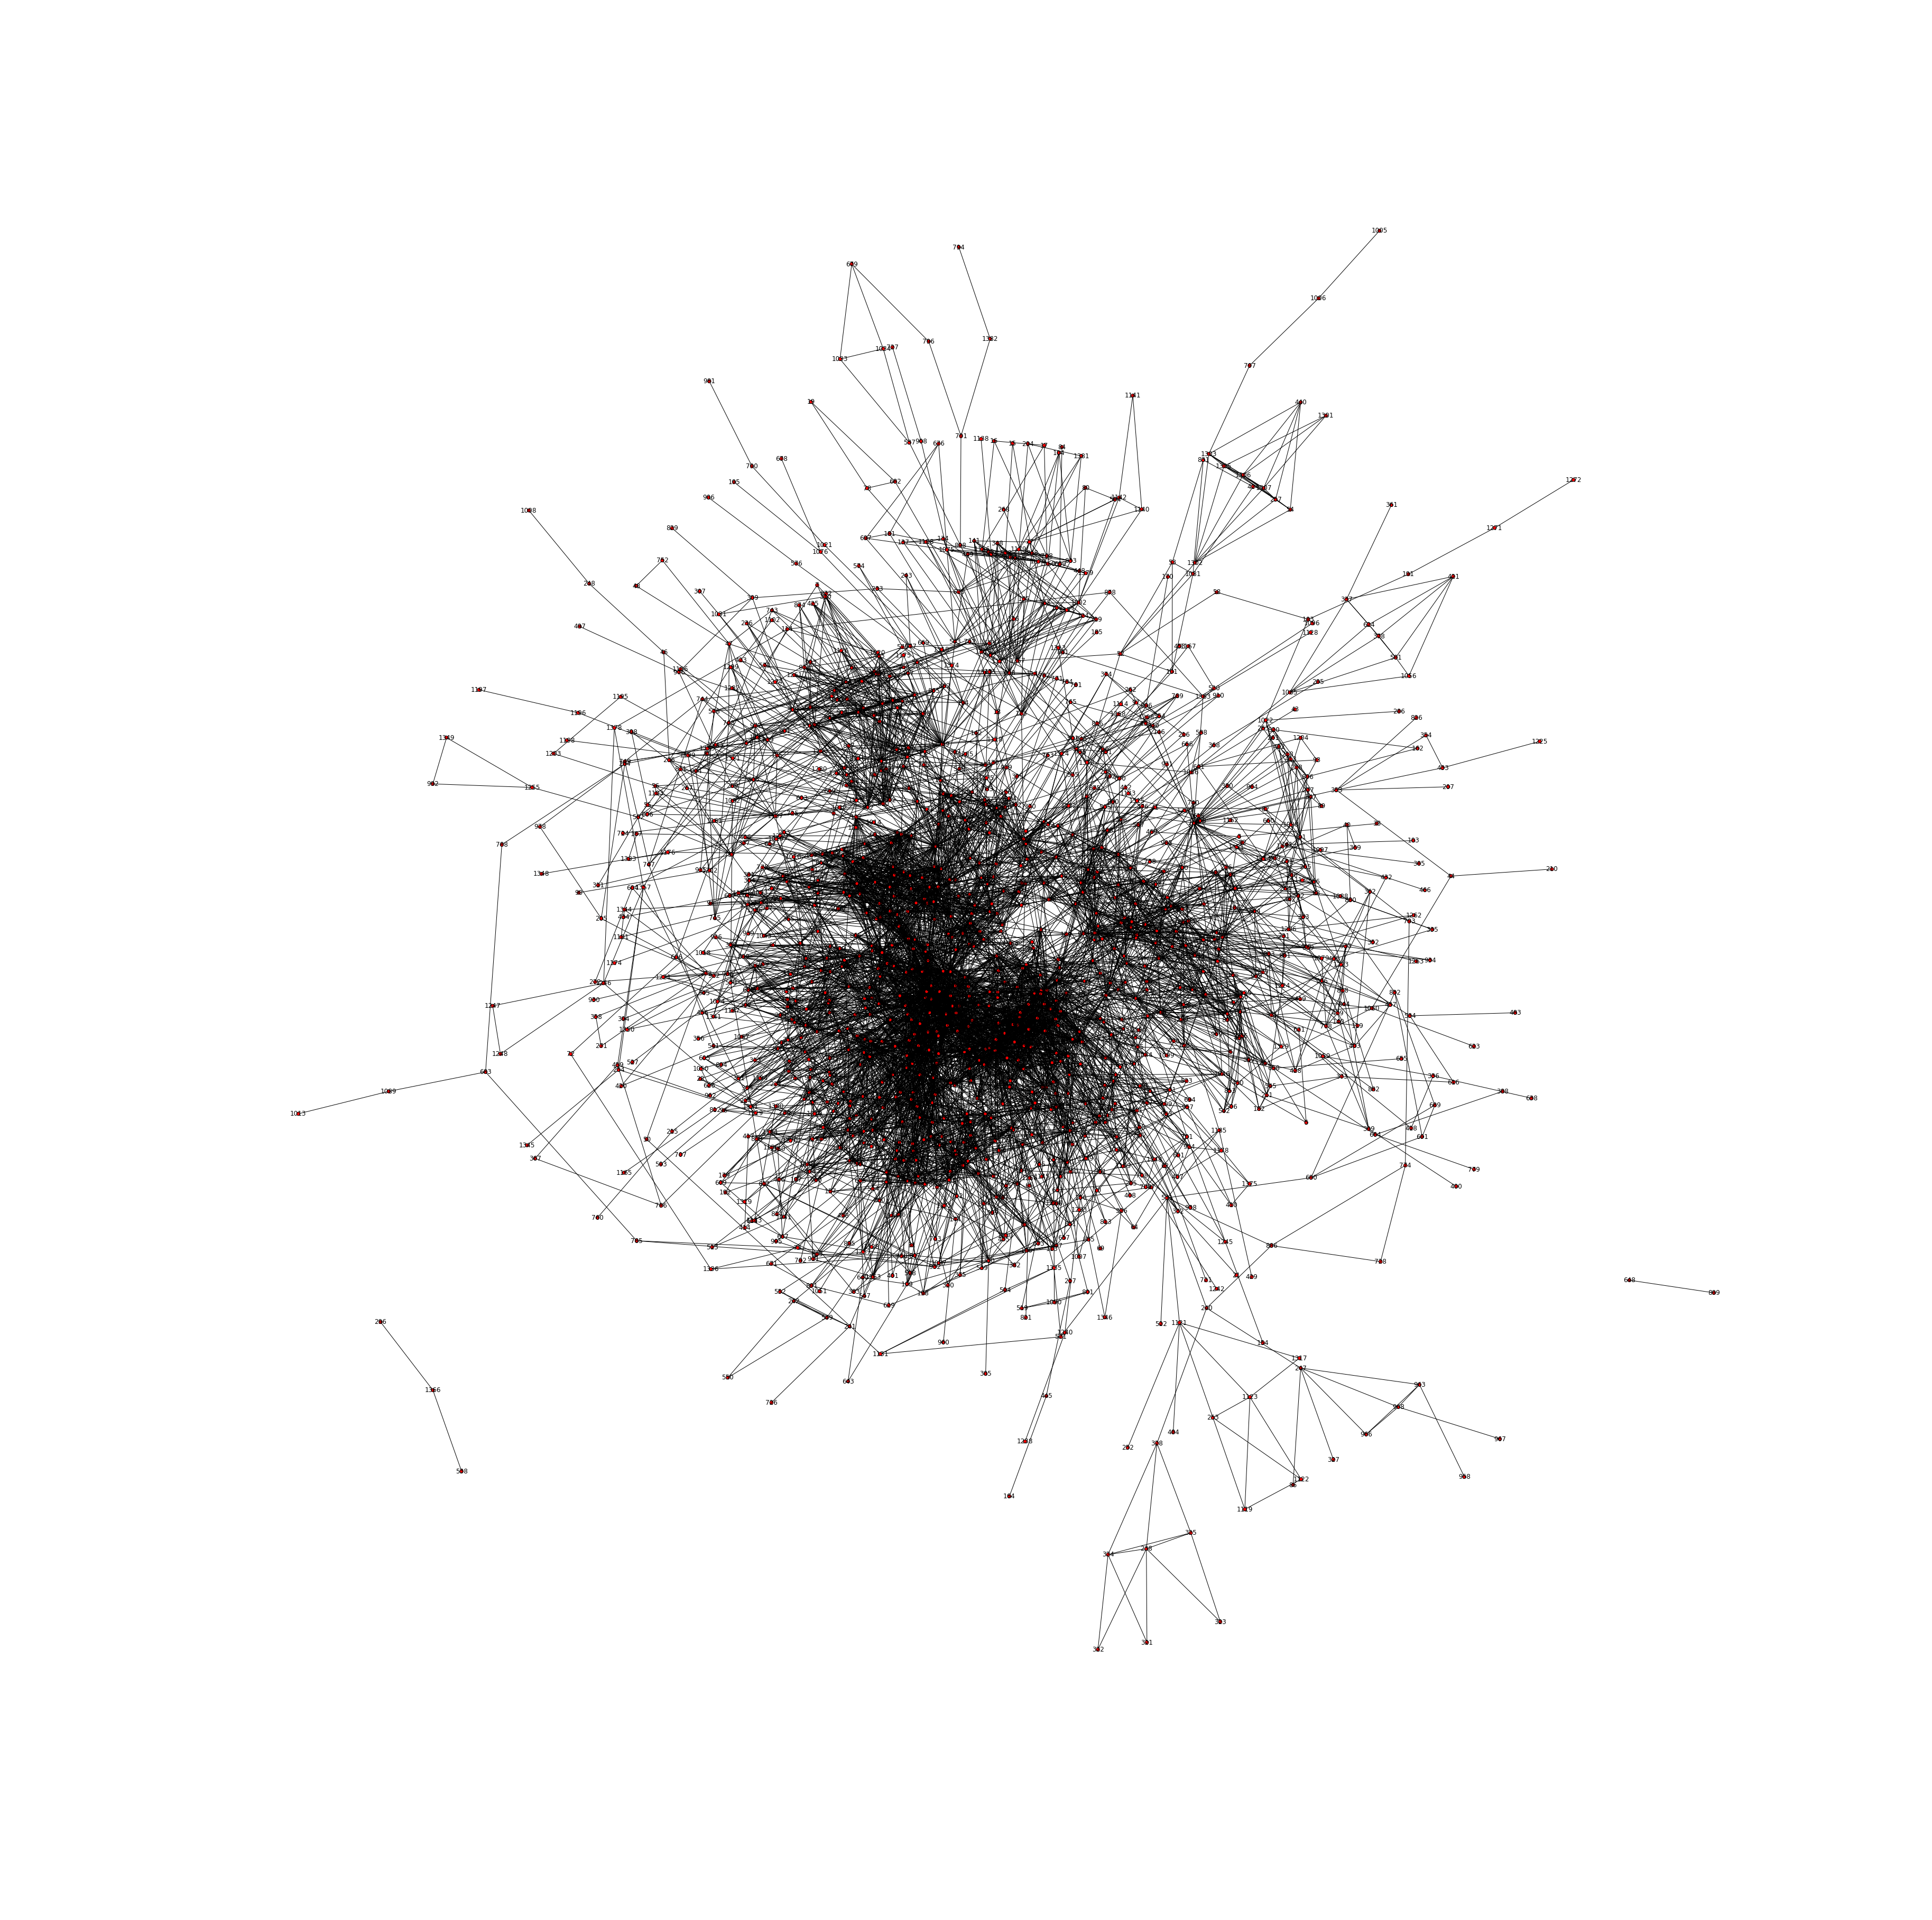

In [73]:
pylab.figure(1, figsize=(50, 50))
# layout graphs with positions using graphviz neato
pos = graphviz_layout(mgh.G.G_genre_sim, prog="neato")
nx.draw(mgh.G.G_genre_sim, pos,
             node_size=40,
             vmin=0.0,
             vmax=1.0,
             with_labels=True)